# Derivatives, Regression, Least Squares and Outliers

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur with updates by Ross Beveridge

Latest Update 10/14/2021

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Warmup - Derivatives

To solve linear regression we need to review the concept of derivatives, and how they can be used to find minima/maxima of a function of a single variable.  We will then extend these ideas to multivariate functions like the ones we deal with in machine learning. Armed with this knowledge we revisit linear regression as a simple least-squares optimization problem. Finally, we introduce the notion of an outlier; a data sample that does not fit in.

## Derivatives

As you recall, the derivative of a function of a single variable indicates the steepness of the curve at a given point.

The following figure provides an illustration for the function

$$
f(x) = x^3 + 10 x
$$

with first derivative

$$
\frac{df}{dx}(x) = 3 x^2 + 10
$$

The tangent line, defined by $\frac{df}{dx}$, is drawn for $x = 5$.

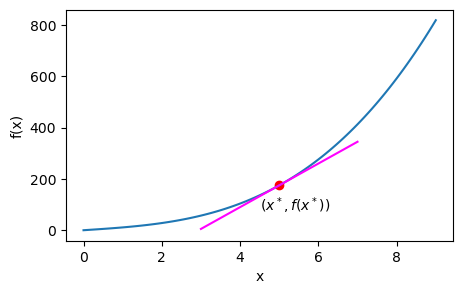

In [2]:
plt.style.use('default')
plt.figure(figsize=(5,3))

def f(x):
    return x**3 + 10*x

def f_deriv(x):
    return (3 * x**2) + 10

x = np.linspace(0,9, 100)
y = f(x)

x1 = 5
y1 = f(x1)
deriv = f_deriv(x1)

plt.xlabel('x')
plt.ylabel('f(x)')

plt.plot(x, y)

plt.scatter(x1,y1, c='red')
plt.annotate(r'$(x^*,f(x^*))$',(x1,y1), xytext=(x1-0.5, y1-100))

# plot the tangent line at the point (x1,y1)
xMin = x1 - 2
yMin = y1 - (2*deriv)
xMax = x1 + 2
yMax = y1 + (2*deriv)
plt.plot([xMin,xMax],[yMin,yMax], color='magenta');


To summarize what is shown, the line tangent to $f(x)$ at the point $x^* = 5$ has a slope that is equal to the derivative of $f$ at that point. The tangent line is drawn in magenta.

As I find often to be the case, if you have already learned this material once and simply wish a quick refresher (re-introduction) then [Wikepedia](https://en.wikipedia.org/wiki/Derivative) is helpful.

### Derivaties of common function

The following is a review of the derivative rules you will need to take the derivatives of the functions we will encounter in this course.

The *power rule*

\begin{equation}
\frac{d}{dx} x^{n} = nx^{n-1}
\end{equation}

The *product rule*

\begin{equation}
\frac{d}{dx}[f(x)g(x)] = f'(x)g(x) + f(x)g'(x) 
\end{equation}

The *quotient rule*

\begin{equation}
\frac{d}{dx}\left[\frac{f(x)}{g(x)}\right] = \frac{f'(x)g(x) - f(x)g'(x)}{g(x)^2}
\end{equation}


The *chain rule* 

\begin{equation}
\frac{d}{dx}[f(g(x))] = f'(g(x)) \cdot g'(x)
\end{equation}

which can be expressed as:

\begin{equation}
\frac{du}{dx} = \frac{d\!f}{dg}\frac{dg}{dx}
\end{equation}


Differentiating logs and exponentials:

$$
\frac{d}{dx}e^x = e^x
$$

$$
\frac{d}{dx}\log x = \frac{1}{x}
$$


### Finding maxima and minima

To find the minimum/maximum of a function, look for points at which the derivative is 0.

Consider for example the function $f(x) = x^2 + 10x$.

The derivative:

$$
\frac{d\!f}{dx} = 2x + 10
$$

Setting the derivative to 0 and solving for $x$ we find that the minimum is at $x=-5$.

How did we know that it's a minimum and not a maximum?  That is based on the sign of the second derivative (positive for a minimum, negative for a maximum, zero for a saddle point).

Let's see a plot of the function:

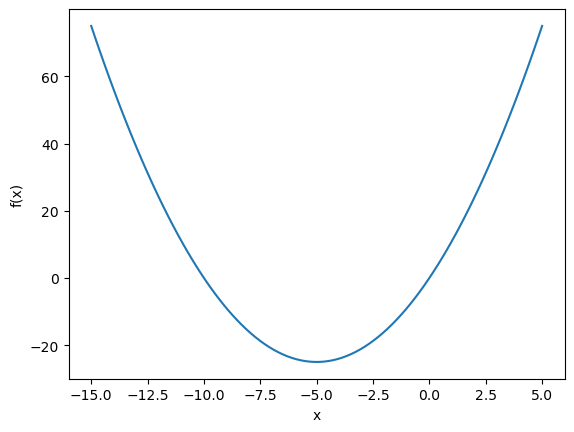

In [3]:
def f(x):
    return x**2 + 10*x

def f_deriv(x):
    return 2*x + 10

x = np.linspace(-15,5,100)
y = f(x)

plt.xlabel('x')
plt.ylabel('f(x)')

plt.plot(x, y)

In this case the function has a single global minimum.  Often, we are not so lucky.
Consider for example the function

$$
g(x) = x^4 + 7x^3 + 5x^2 - 17x
$$

with first derivative

$$
\frac{dg}{dx} = 4 x^{3} + 21 x^{2} + 10 x - 17
$$

As the following plot shows, this function has multiple minima.   

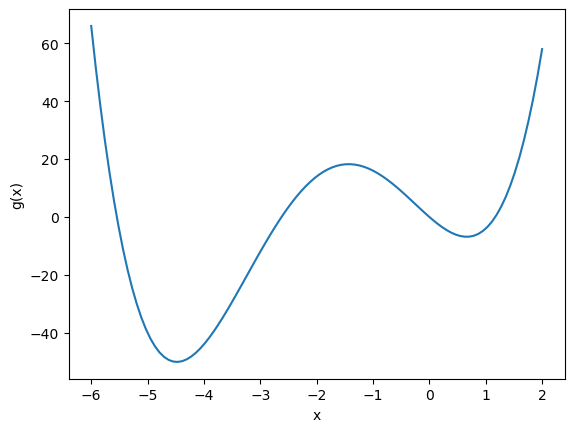

In [4]:
np.set_printoptions(precision=2)

def g(x):
    return x**4 + 7*x**3 + 5*x**2 -17*x

def g_deriv(x):
    return 4*x**3 + 21*x**2 + 10*x - 17

x = np.linspace(-6, 2, 100)

plt.xlabel('x')
plt.ylabel('g(x)')

plt.plot(x, g(x))

Observe that there is one global minimum and another local minima. As you would expect, the global minima of a function is that - hopefully unique - point on the curve or surface that is lower than **all** other points. Of local minima, there may and in real machine learning problems are generally, many.  A local minima just means a point from which the values of the function increase as small steps are taken away from the local minima.

When the nature of the function, as with for example $g(x)$ limits the number of local minima to a few exhaustively trying them all is appropriate. However, generally this approach is impossible and instead some form of iterative search process is employed to locate a local minima. 



## Using derivatives to iteratively reach the minimum

For a function of a single variable, the derivative points us to the direction at which we would find a local minimum.  Well, actually it points at the opposite direction, so we would need to consider the negative of the derivative.
The idea is to take small steps in the direction of the negative of the derivative, which should converge to a local minimum.  
This insight translates to the following algorithm:

* Initialize $x(0),\eta$
* for $t = 0,1,\ldots$
  * $x(t+1) = x(t) - \eta \frac{d\!f}{dx}(x(t))$
  * if converged, break
  
Let's illustrate this with the function $g$ we defined above:

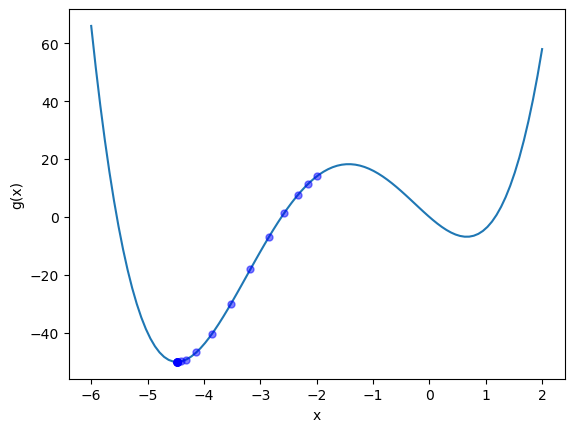

In [5]:
def g(x):
    return x**4 + 7*x**3 + 5*x**2 -17*x

def g_deriv(x):
    return 4*x**3 + 21*x**2 + 10*x - 17

eta = 0.01
x0 = -2.0 # the initial value
max_steps = 20

x_list = [x0]
y_list = [g(x0)]
for t in range(1, max_steps):
    x_new = x_list[-1] - (eta * g_deriv(x_list[-1]))
    x_list.append(x_new)
    y_list.append(g(x_new))
        
x_grid = np.linspace(-6, 2, 100)

plt.xlabel('x')
plt.ylabel('g(x)')

plt.plot(x_grid, g(x_grid));
plt.plot(x_list, y_list, 'ob', markersize=5, alpha=0.50);

In the example above, with the starting point chosen, we were able to find the global minimum of this function.  However, with a different choice, we might only find a **local minimum**:


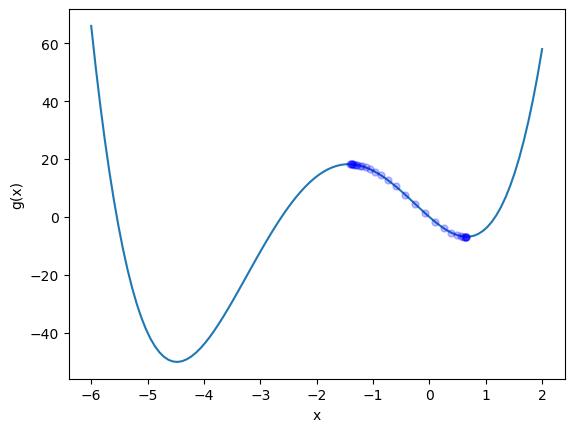

In [6]:
eta = 0.01
x0 = -1.4 # near the tipping point

x0 = -1.4
x_list = [x0]
y_list = [g(x0)]
max_steps = 30

for t in range(1, max_steps):
    x_new = x_list[-1] - (eta * g_deriv(x_list[-1]))
    x_list.append(x_new)
    y_list.append(g(x_new))
        
x_grid = np.linspace(-6, 2, 100)

plt.xlabel('x')
plt.ylabel('g(x)')

plt.plot(x_grid, g(x_grid));
plt.plot(x_list, y_list, 'ob', markersize=5, alpha=0.25);

## Step It Up a Bit

Now consider the following more complex fuction

$$
f(x) = x  (3  \pi - x) \sin(2 \pi x )
$$

$$
\frac{df}{dx} = (3 * \pi - 2 x) \sin(2 \pi x ) + 2 \pi x (3 \pi - x) \cos(2 \pi x)
$$

And a little truth in advertising - I do not compute these derivatives by hand (See [Wolfram Page](https://www.wolframalpha.com/input/?i2d=true&i=D%5Bx+%5C%2840%293*pi+-+x%5C%2841%29+Sin%5B2+*+pi+*+x%5D%2Cx%5D) )

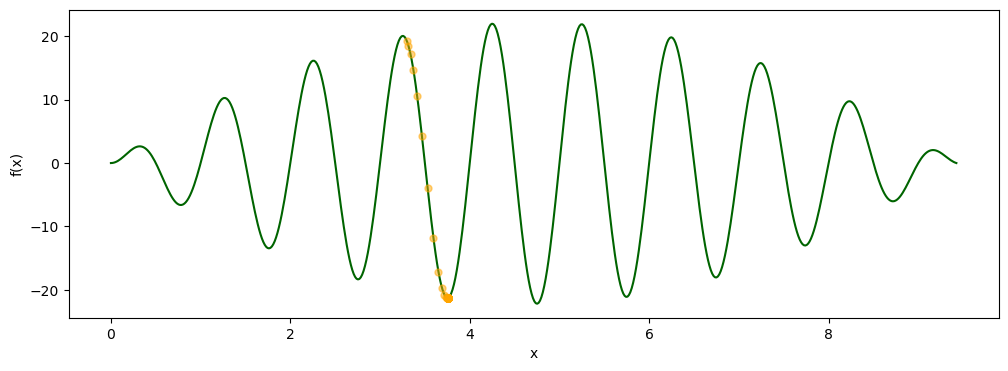

In [7]:
from numpy.random import default_rng

def g(x, res=0.0) :
    return x * (3 * np.pi - x) * np.sin(2 * np.pi * x)

def g_deriv(x, res=0.0) :
    res = ((3 * np.pi - x) * np.sin(2 * np.pi * x)) + ((2 * np.pi * x) * (3 * np.pi - x) * np.cos(2 * np.pi * x))
    return res

eta = 0.0005
x0 = 3.3
x_list = [x0]
y_list = [g(x0)]
max_steps = 100

for t in range(1, max_steps):
    x_new = x_list[-1] - (eta * g_deriv(x_list[-1]))
    x_list.append(x_new); y_list.append(g(x_new))
        
x_grid = np.linspace(0, 3*np.pi, 600)

fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(111)

ax.set_xlabel('x')
ax.set_ylabel('f(x)')
ax.plot(x_grid, g(x_grid), color='darkgreen')
ax.plot(x_list, y_list, 'ob', color='orange', markersize=5, alpha=0.5)
pass

# Partial Derivatives and Functions with 2 Parameters

Until now, we considered derivatives of functions of a single variable.
Next, we are going to consider functions of multiple variables, e.g.:

$$f(x_1,x_2) = x_1^2 + x_2^2$$

We can take a derivative with respect to either $x_1$ or $x_2$. 
A derivative with respect to a variable while holding the others constant is called the **partial derivative**.  The partial derivative with respect to $x_1$ is denoted as

$$\frac{\partial f(x_1,x_2)}{\partial x_1} = \frac{\partial (x_1^2 + x_2^2)}{\partial x_1}$$

$f(x_1,x_2)$ is the sum of two terms.  The first is a polynomial in $x_1$ for which we use the power rule, while the second is constant when considered a function of $x_1$.  Therefore we have that:

$$\frac{\partial (x_1^2 + x_2^2)}{\partial x_1} = 2x_1$$

Overall we have two partial derivatives for this function:

$$\frac{\partial f(x_1,x_2)}{\partial x_1} = 2x_1 \\
\frac{\partial f(x_1,x_2)}{\partial x_2} = 2x_2$$

Setting the partial derivatives to 0 and solving for $x_1,x_2$ tells us that $(0,0)$ is an extremum point for $f$.  (An extremum point is a maximum, minimum or saddle point).
The condition for determining that an extremum point is indeed a minimum/maximum for multi-variate functions is more complex than for univariate functions, and will not be discussed in this course.

## Finding the solution to univariate linear regression

Objective:  find $(w,b)$ that minimize 
$$
J( w,b ) = \sum_{i=1}^N (y_i - \hat{y}_i)^2.
$$
For univariate linear regression this takes on the form:
$$
J( w,b ) = \sum_{i=1}^N (y_i - (w x_i + b))^2.
$$

To find the solution, we take the partial derivatives, set them to 0 and solve for $w$ and $b$.
Verify that 
$$
\frac{\partial J}{\partial w} = -2 \sum_{i=1}^n x_i(y_i - (w x_i + b))
$$
and
$$
\frac{\partial J}{\partial b} = -2 \sum_{i=1}^n (y_i - (w x_i + b))
$$

Below is one straight forward way to solve these two equations


## Univariate Linear Regression Solved from Scratch

From above note we are starting with two equations in the two unkonwns $w$ and $b$

$$
\begin{eqnarray}
 \sum_{i=1}^n x_i(y_i - (w x_i + b)) & = & 0 \\
 \sum_{i=1}^n (y_i - (w x_i + b)) & = & 0
\end{eqnarray}
$$

which can be rewritten as

$$
\begin{eqnarray}
 \sum_{i=1}^n x_i y_i - w \sum_{i=1}^n  x_i^2 - b \sum_{i=1}^n x_i  & = & 0 \\
 \sum_{i=1}^n y_i - w \sum_{i=1}^n x_i - \sum_{i=1}^n b & = & 0
\end{eqnarray}
$$

For reasons that will soon become apparent, let us multiply both sides of both equations by $\frac{1}{n}$

$$
\begin{eqnarray}
 \frac{1}{n} \sum_{i=1}^n x_i y_i -  w \frac{1}{n} \sum_{i=1}^n  x_i^2 - b \frac{1}{n} \sum_{i=1}^n x_i  & = & 0 \\
 \frac{1}{n} \sum_{i=1}^n y_i - w \frac{1}{n} \sum_{i=1}^n x_i - b \frac{1}{n} \sum_{i=1}^n 1 & = & 0
\end{eqnarray}
$$

Now notice that the summations can all be simplified, if you will, think of them as something computed in advance:

$$
\mu_x  =  \frac{1}{n} \sum_{i=1}^n x_i \quad 
\mu_y  =  \frac{1}{n} \sum_{i=1}^n y_i \quad \quad
a_1    =  \frac{1}{n} \sum_{i=1}^n x_i y_i \quad 
a_2    =  \frac{1}{n} \sum_{i=1}^n  x_i^2
$$

Now the reason for the $\frac{1}{n}$ being added is we see that the first terms are just the average $x$ and the average $y$ values. The $a$ coeficients are related to variances but not the same (no mean subtraction) so the more neutral symbels $a_1$ and $a_2$ are chosen. With these summations simplified and named we have:


$$
\begin{eqnarray}
 a_1 - w a_2 - b \mu_x  & = & 0 \\
 \mu_y - w \mu_x - b  & = & 0
\end{eqnarray}
$$

The second equation may be rearranged to solve for $b$

$$
\mu_y - \mu_x w - b   =  0 \\ b = \mu_y - \mu_x w 
$$

Substitute into the first equation and solve for $w$

$$
 a_1 - a_2 w - \mu_x (\mu_y - \mu_x w ) = 0 
 \longrightarrow 
 a_1 - \mu_x \mu_y =  a_2 w -\mu_x^2 w 
$$

Finally, here is both the solution for $w$ and for completeness sake the solution for $b$ taken from above:

$$
\begin{eqnarray}
w & = & \frac{a_1 - \mu_x \mu_y}{ a_2 - \mu_x^2} \\
b & = & \mu_y - \mu_x w 
\end{eqnarray}
$$

# Use the Above for Regression

To test our math and also see the above in action, here is code that replicates the linear regression example from the previous notebook, but using our derived version in place of support code written elsewhere.

## Use LinearRegression from sklearn

First recall the example from our earlier notebook on linear regression and the use of the sklearn linear regression model in particular

In [8]:
def regression_example_data(seed=5) :
    from numpy.random import default_rng
    rng = default_rng(seed)
    nsamples = 15
    xmax = 20
    slope = 0.5
    intersept = 5
    sigma = 3
    x = xmax * rng.random(nsamples)
    y = slope * x + intersept + rng.standard_normal(nsamples) * sigma
    return x, y

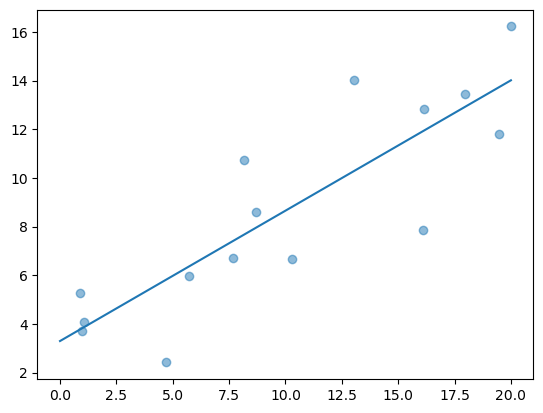

In [9]:
from sklearn.linear_model import LinearRegression

def regression_example_sklearn(seed=5,equation=True) :
    x,y = regression_example_data(seed)  
    # instantiate and fit
    model = LinearRegression()
    model.fit(x[:, np.newaxis], y)
    # data for plotting the regression line
    xs = np.linspace(0, 20, 1000)
    ys = model.predict(xs[:, np.newaxis])
    # plot the regression line
    plt.scatter(x, y, alpha=0.5)
    plt.plot(xs, ys)
    return None

regression_example_sklearn()

## Match Using Our Own Code

Now buid from scratch an equivalent tool for performing linear regression. And to make comparisons between code and algebrar here are key equations copied down from above:


$$
\mu_x  =  \frac{1}{n} \sum_{i=1}^n x_i \quad 
\mu_y  =  \frac{1}{n} \sum_{i=1}^n y_i \quad \quad
a_1    =  \frac{1}{n} \sum_{i=1}^n x_i y_i \quad 
a_2    =  \frac{1}{n} \sum_{i=1}^n  x_i^2
$$

$$
\begin{eqnarray}
w & = & \frac{a_1 - \mu_x \mu_y}{ a_2 - \mu_x^2} \\
b & = & \mu_y - \mu_x w 
\end{eqnarray}
$$


In [10]:
class OurLinearRegression:
    def __init__(self):
        pass
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.mu_x = sum(x)/len(x)
        self.mu_y = sum(y)/len(y)
        self.a1 = sum(x * y)/len(x)
        self.a2 = sum(x * x)/len(x)
        self.w = (self.a1 - (self.mu_x * self.mu_y))/(self.a2 - self.mu_x**2)
        self.b = self.mu_y - (self.mu_x * self.w)  
    def predict(self, x) :
        return self.w * x + self.b

In [11]:
def fit_and_plot (x,y) :
    # instantiate and fit
    model = OurLinearRegression()
    model.fit(x, y)
    # data for plotting the regression line
    xs = np.linspace(0, 20, 1000)
    ys = model.predict(xs)
    # plot the regression line
    plt.scatter(x, y, alpha=0.5)
    plt.plot(xs, ys)
    return None  

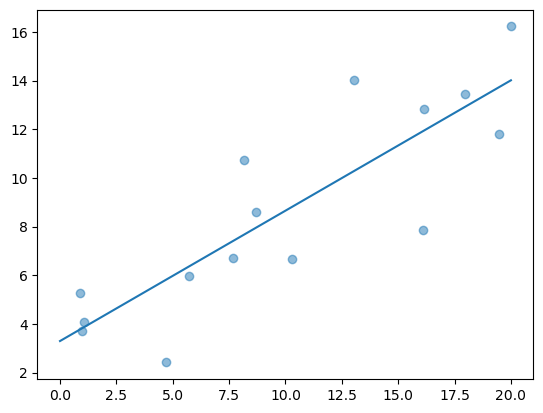

In [12]:
def regression_example_ours(seed=5,equation=True) :
    x,y = regression_example_data(seed)
    fit_and_plot(x,y)
regression_example_ours()

# One More Thing: Outliers

Techniques based on minimizing a sum of least squares error function are particularly vulnerable to `outliers`.  Take some care with the concept of [Outlier](https://en.wikipedia.org/wiki/Outlier) - it is a term both indespensible and also sometimes problematic in real life.  In other words, judging a sample as a outlier in a real and complex domain may be tricky. For now, let us simply work in the realm where outliers are relatively obvious and consider and approach that removes them from a regression solution.

## Polluting Our Previous Example

Here is the example from above with only a single point alterred so that it does not fit the model. You should have no trouble visually spotting the outlier.

In [13]:
def regression_outlier_example_data(seed=5) :
    x,y = regression_example_data(seed)  
    x[0] = 1; y[0] = 15
    return x,y

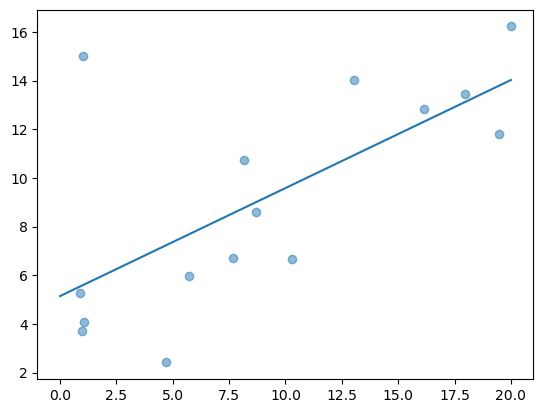

In [14]:
def regression_example_ours(seed=5,equation=True) :
    x,y = regression_outlier_example_data(seed)
    fit_and_plot(x,y)
    return None

regression_example_ours()

## Iterative Removal of Worst Fit

Outlier removal is by nature a heuristic technique because true knowledge of the true outlier(s) is typically hidden. That said, a common and useful heuristic is remove the worst fitting sample and redo the regression. That procedure is exactly what you will find implemented below.

In [15]:
class RobustLinearRegression:
    def __init__(self):
        pass
    def fit(self, x, y) :
        self.x = x
        self.y = y
        self.fit_solve()
    def fit_solve(self) :
        self.mu_x = sum(self.x)/len(self.x)
        self.mu_y = sum(self.y)/len(self.y)
        self.a1 = sum(self.x * self.y)/len(self.x)
        self.a2 = sum(self.x * self.x)/len(self.x)
        self.w = (self.a1 - (self.mu_x * self.mu_y))/(self.a2 - self.mu_x**2)
        self.b = self.mu_y - (self.mu_x * self.w)  
    def predict(self, x) :
        return self.w * x + self.b
    def drop(self) :
        dsts  = [(self.predict(self.x[i])-self.y[i])**2 for i in range(len(self.x))]
        dropi = np.argmax(dsts)
        self.x = np.delete(self.x,[dropi])
        self.y = np.delete(self.y,[dropi])       
        self.fit_solve()
        return self.x, self.y

In [16]:
def fit_and_plot_robust (x,y) :
    # instantiate and fit
    model = RobustLinearRegression()
    model.fit(x, y)
    
    xs = np.linspace(0, 20, 1000) ; ys = model.predict(xs)
    plt.scatter(x, y, color="darkred", alpha=0.5)
    plt.plot(xs, ys, color="darkred")
    
    x, y = model.drop()
    xs = np.linspace(0, 20, 1000) ; ys = model.predict(xs)
    plt.scatter(x, y, color="darkgreen", alpha=0.5)
    plt.plot(xs, ys, color="darkgreen")    
    return None  

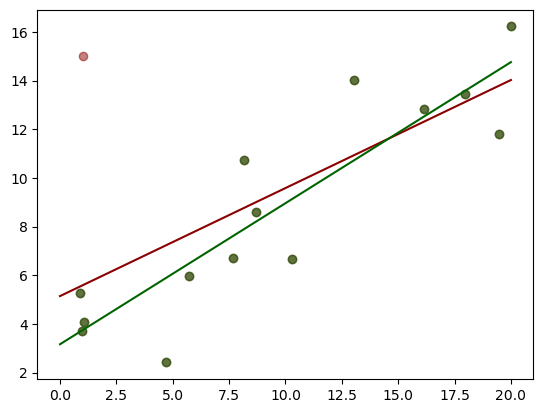

In [18]:
def regression_example_robust(seed=5,equation=True) :
    x,y = regression_outlier_example_data(seed)
    fit_and_plot_robust(x,y)
    return None
regression_example_robust()